# Regression with CT Image Features
***

### 1. Importing Libraries/ Packages

In [128]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import pydicom as dicom
import cv2
import pandas as pd

In [132]:
from sklearn.preprocessing import *

In [28]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [29]:
import random
from PIL import Image

In [61]:
import tensorflow as tf
import tensorflow_io as tfio

### 2. Selecting Base CT image slice for each Patient

#### Logic for slice selection:
- The number of CT images vary from patient to patient
- The initial CT slices and the slices towards the end do not provide much information about the lungs.
- Therefore, randomly selected an image between 30% to 70% range of the CT slices.

In [30]:
data_path= '../data/osic-pulmonary-fibrosis-progression/train'

In [31]:
folder_list= os.listdir(data_path)

In [32]:
len(folder_list)

176

In [51]:
image_dict={}

for item in folder_list:
    img_path= '../data/osic-pulmonary-fibrosis-progression/train/' + item
    img_list= os.listdir(img_path)
    img_list.sort()
    total_img= len(img_list)
    sub_image_list= img_list[int(total_img*.3):int(total_img*.7)] # slicing the images from 30% to 70%
    image_dict[item]= random.choice(sub_image_list)   

In [34]:
image_dict

{'ID00007637202177411956430': '24.dcm',
 'ID00009637202177434476278': '208.dcm',
 'ID00010637202177584971671': '41.dcm',
 'ID00011637202177653955184': '23.dcm',
 'ID00012637202177665765362': '30.dcm',
 'ID00014637202177757139317': '23.dcm',
 'ID00015637202177877247924': '287.dcm',
 'ID00019637202178323708467': '20.dcm',
 'ID00020637202178344345685': '34.dcm',
 'ID00023637202179104603099': '21.dcm',
 'ID00025637202179541264076': '16.dcm',
 'ID00026637202179561894768': '224.dcm',
 'ID00027637202179689871102': '301.dcm',
 'ID00030637202181211009029': '215.dcm',
 'ID00032637202181710233084': '31.dcm',
 'ID00035637202182204917484': '423.dcm',
 'ID00038637202182690843176': '236.dcm',
 'ID00042637202184406822975': '382.dcm',
 'ID00047637202184938901501': '54.dcm',
 'ID00048637202185016727717': '16.dcm',
 'ID00051637202185848464638': '38.dcm',
 'ID00052637202186188008618': '196.dcm',
 'ID00060637202187965290703': '179.dcm',
 'ID00061637202188184085559': '182.dcm',
 'ID00062637202188654068490':

In [35]:
len(image_dict)

176

### 3. Feature Extraction using VGG16

#### 3.1 Load Images

In [108]:
image_load= []
patientID= []
SIZE = 256
abs_path= r'C:\Users\pinak\Desktop\MS LJMU\Topic selection & research\Notebooks\data\osic-pulmonary-fibrosis-progression\images_shortlisted'

for key,value in image_dict.items():
    imagePath = data_path + '/' + key + '/' + value
    
    image_bytes = tf.io.read_file(imagePath)
    image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)
    
    
    img= (np.squeeze(image.numpy())).astype(float)
    
    scaled_image = (np.maximum(img, 0) / img.max()) * 255.0
    scaled_image = np.uint8(scaled_image)
    final_image = Image.fromarray(scaled_image)
    
    final_image_path= abs_path + '/' + key + '.png'
    
    final_image.save(final_image_path, 'PNG')
    
    read_img= cv2.imread(final_image_path)
    
    read_img = cv2.resize(read_img, (SIZE, SIZE))
    read_img = cv2.cvtColor(read_img, cv2.COLOR_RGB2BGR)
    
    image_load.append(read_img)
    patientID.append(key)

#### 3.2 Load and configure VGG16

In [92]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

#### 3.3 Extract Features from Images

In [109]:
image_normalized= np.array(image_load)/255.0

In [110]:
feature_extractor=VGG_model.predict(image_normalized)

In [114]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [119]:
features[0]

array([0.0514673, 0.       , 0.       , ..., 0.       , 0.6658163,
       0.       ], dtype=float32)

In [150]:
#Creating feature dictionary
feature_dict= {}
for i in range(len(patientID)):
    feature_dict[patientID[i]]= features[i]

In [151]:
feature_dict

{'ID00007637202177411956430': array([0.0514673, 0.       , 0.       , ..., 0.       , 0.6658163,
        0.       ], dtype=float32),
 'ID00009637202177434476278': array([0.08189972, 0.        , 0.        , ..., 0.        , 0.93886065,
        0.        ], dtype=float32),
 'ID00010637202177584971671': array([0.07631595, 0.        , 0.        , ..., 0.        , 1.0944773 ,
        0.        ], dtype=float32),
 'ID00011637202177653955184': array([0.        , 0.        , 0.        , ..., 0.        , 0.61557317,
        0.        ], dtype=float32),
 'ID00012637202177665765362': array([0.08156772, 0.        , 0.        , ..., 0.        , 0.6182562 ,
        0.        ], dtype=float32),
 'ID00014637202177757139317': array([0.14110121, 0.        , 0.        , ..., 0.        , 0.582663  ,
        0.        ], dtype=float32),
 'ID00015637202177877247924': array([0.14498565, 0.        , 0.        , ..., 0.        , 1.2565091 ,
        0.        ], dtype=float32),
 'ID00019637202178323708467': arr

In [144]:
np.mean(features[7])

0.09580837

### 4. Loading and processing tabular data

In [180]:
patient_data = pd.read_csv('../data/osic-pulmonary-fibrosis-progression/train.csv')

In [181]:
# Dropping duplicate records in th train data
patient_data.drop_duplicates(subset=['Patient', 'Weeks'], keep=False, inplace=True)
patient_data.shape

(1535, 7)

#### 4.1 Encoding categorical columns [ 'Sex', 'SmokingStatus']
- Sex { Male:1 | Female:0 }
- SmokingStatus { Ex-smoker:1 | Never smoked:2 | Currently smokes:0 }

In [182]:
le = LabelEncoder()

# Encoding 'Sex' column in Patient data
patient_data['Sex'] = le.fit_transform(patient_data['Sex'])

# Encoding 'SmokingStatus' column Patient data
patient_data['SmokingStatus'] = le.fit_transform(patient_data['SmokingStatus'])

In [183]:
patient_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,1,1
1,ID00007637202177411956430,5,2214,55.712129,79,1,1
2,ID00007637202177411956430,7,2061,51.862104,79,1,1
3,ID00007637202177411956430,9,2144,53.950679,79,1,1
4,ID00007637202177411956430,11,2069,52.063412,79,1,1


#### 4.2 Transforming Patient data w.r.to 1st week's measurement
- Each of the patient's measurements will be appended by 1st week's measurements
- New schema of the dataframe- ['PatientID', 'first_week', 'first_FVC',	'Age',	'Sex',	'SmokingStatus',	'target_week',	'target_FVC']

In [184]:
# create training data
data_point = []

# itrating through the train data and appening each measurement w.r.to 1st week's measurement
for p in patient_data['Patient'].unique():
    patientData = patient_data[patient_data['Patient'] == p]
    firstMeasure = list(patientData.iloc[0, :].values)
        
    for i, week in enumerate(patientData['Weeks'].iloc[1:]):
        fvc = patientData.iloc[i, 2]
        DataPoint = firstMeasure + [week, fvc]
        data_point.append(DataPoint)
    
# creating final dataframe for training        
patient_data_v2 = pd.DataFrame(data_point)
patient_data_v2.columns = ['PatientID', 'first_week', 'first_FVC', 'first_Percent', 'Age', 'Sex', 'SmokingStatus'] + ['target_week', 'target_FVC']

patient_data_v2.head()

,PatientID,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,target_FVC
0,ID00007637202177411956430,-4,2315,58.253649,79,1,1,5,2315
1,ID00007637202177411956430,-4,2315,58.253649,79,1,1,7,2214
2,ID00007637202177411956430,-4,2315,58.253649,79,1,1,9,2061
3,ID00007637202177411956430,-4,2315,58.253649,79,1,1,11,2144
4,ID00007637202177411956430,-4,2315,58.253649,79,1,1,17,2069


#### 4.3 Rescaling Numerical Variables
Columns rescaled = [ 'first_week', 'first_FVC',	'first_Percent',	'Age', 'target_week', 'target_FVC' ]

In [185]:
# importing sklearn minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [186]:
# Apply scaler() to all numerical varibales
num_vars =  [ 'first_week', 'first_FVC', 'first_Percent', 'Age', 'target_week', 'target_FVC' ]
patient_data_v2[num_vars] = scaler.fit_transform(patient_data_v2[num_vars])

In [187]:
patient_data_v2.head()

,PatientID,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,target_FVC
0,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.030303,0.267050
1,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.045455,0.248923
2,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.060606,0.221464
3,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.075758,0.236360
4,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.121212,0.222900


#### 4.4 Appending CT image features to the tabular data 

In [214]:
# create training data
data_point = []

# itrating through the train data and appening each measurement w.r.to 1st week's measurement
for p in patient_data_v2['PatientID'].unique():
    patientData = patient_data_v2[patient_data_v2['PatientID'] == p]
    data= patientData.values
    img_feature=  list(feature_dict[p])    
    for item in data:
        
        DataPoint = list(item) + img_feature
        data_point.append(DataPoint)
    
# creating final dataframe for training        
patient_data_v3 = pd.DataFrame(data_point)
column_names= {0:'PatientID',1: 'first_week', 2:'first_FVC', 3: 'first_Percent',4: 'Age', 5:'Sex', 6:'SmokingStatus', 7: 'target_week', 8 :'target_FVC'}
patient_data_v3.rename(columns= column_names, inplace= True)


In [215]:
patient_data_v3

,PatientID,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,target_FVC,9,...,32767,32768,32769,32770,32771,32772,32773,32774,32775,32776
0,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.030303,0.267050,0.051467,...,1.756420,0.070229,0.507159,0.000000,0.0,0.225594,0.000000,0.0,0.665816,0.0
1,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.045455,0.248923,0.051467,...,1.756420,0.070229,0.507159,0.000000,0.0,0.225594,0.000000,0.0,0.665816,0.0
2,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.060606,0.221464,0.051467,...,1.756420,0.070229,0.507159,0.000000,0.0,0.225594,0.000000,0.0,0.665816,0.0
3,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.075758,0.236360,0.051467,...,1.756420,0.070229,0.507159,0.000000,0.0,0.225594,0.000000,0.0,0.665816,0.0
4,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.121212,0.222900,0.051467,...,1.756420,0.070229,0.507159,0.000000,0.0,0.225594,0.000000,0.0,0.665816,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,ID00426637202313170790466,0.059524,0.354755,0.259644,0.615385,1,2,0.090909,0.385678,0.070851,...,1.675267,0.000000,0.373213,0.106312,0.0,0.073122,0.070889,0.0,1.610480,0.0
1355,ID00426637202313170790466,0.059524,0.354755,0.259644,0.615385,1,2,0.136364,0.338299,0.070851,...,1.675267,0.000000,0.373213,0.106312,0.0,0.073122,0.070889,0.0,1.610480,0.0
1356,ID00426637202313170790466,0.059524,0.354755,0.259644,0.615385,1,2,0.227273,0.386037,0.070851,...,1.675267,0.000000,0.373213,0.106312,0.0,0.073122,0.070889,0.0,1.610480,0.0
1357,ID00426637202313170790466,0.059524,0.354755,0.259644,0.615385,1,2,0.318182,0.373475,0.070851,...,1.675267,0.000000,0.373213,0.106312,0.0,0.073122,0.070889,0.0,1.610480,0.0


#### 4.5 Train/ Test Split 
- Splitting the dataset into train and test set (80:20)

In [216]:
# importing sklearn
from sklearn.model_selection import train_test_split

In [217]:
# spliting train and test sets in 70-30 proportion
np.random.seed(0)
patient_train, patient_test = train_test_split(patient_data_v3, train_size = 0.8, test_size = 0.2, random_state = 100)

In [218]:
# Checking the shape of train and test set
print('Train Set: ',  patient_train.shape)
print('Test Set: ',  patient_test.shape)

Train Set:  (1087, 32777)
Test Set:  (272, 32777)


### 5. Linear Regression Model
- A linear regression model will be build using all the features present in train data set
- Target Variable- **'target_FVC'**

#### 5.1 Building model using train data

In [219]:
patient_train

,PatientID,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,target_FVC,9,...,32767,32768,32769,32770,32771,32772,32773,32774,32775,32776
1271,ID00401637202305320178010,0.559524,0.217125,0.337683,0.641026,0,1,0.530303,0.165650,0.129798,...,1.758800,0.093809,0.527530,0.0,0.0,0.191229,0.0,0.0,0.699518,0.0
708,ID00216637202257988213445,0.178571,0.305163,0.248965,0.410256,1,2,0.250000,0.245513,0.082673,...,1.715087,0.065284,0.337167,0.0,0.0,0.322502,0.0,0.0,0.567114,0.0
661,ID00199637202248141386743,0.142857,0.344168,0.238230,0.333333,1,1,0.310606,0.359835,0.079290,...,1.722066,0.048731,0.362179,0.0,0.0,0.309212,0.0,0.0,0.586829,0.0
1007,ID00317637202283194142136,0.369048,0.252600,0.128612,0.384615,1,1,0.636364,0.148241,0.047341,...,1.773836,0.074910,0.539025,0.0,0.0,0.215250,0.0,0.0,0.719077,0.0
434,ID00129637202219868188000,0.059524,0.229941,0.148365,0.564103,1,2,0.030303,0.243539,0.082985,...,1.767412,0.072002,0.372934,0.0,0.0,0.313304,0.0,0.0,0.640233,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,ID00235637202261451839085,0.464286,0.194279,0.095999,0.461538,1,1,0.348485,0.232053,0.200210,...,2.057447,0.000000,0.222976,0.0,0.0,0.189120,0.0,0.0,0.982550,0.0
53,ID00015637202177877247924,0.202381,0.376486,0.321839,0.564103,1,1,0.386364,0.335607,0.144986,...,2.271101,0.000000,0.406799,0.0,0.0,0.000000,0.0,0.0,1.256509,0.0
350,ID00110637202210673668310,0.238095,0.182021,0.176328,0.641026,1,1,0.310606,0.046303,0.090161,...,1.773970,0.076977,0.569337,0.0,0.0,0.177016,0.0,0.0,0.733373,0.0
79,ID00025637202179541264076,0.059524,0.350669,0.277450,0.410256,1,1,0.000000,0.372577,0.270002,...,1.752754,0.089913,0.530527,0.0,0.0,0.210201,0.0,0.0,0.666627,0.0


In [220]:
# Spliting train data into predictors and predictee
x_train= patient_train.drop(columns = ['PatientID', 'target_FVC'])
y_train= patient_train['target_FVC']

In [221]:
x_train

,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,9,10,11,...,32767,32768,32769,32770,32771,32772,32773,32774,32775,32776
1271,0.559524,0.217125,0.337683,0.641026,0,1,0.530303,0.129798,0.0,0.0,...,1.758800,0.093809,0.527530,0.0,0.0,0.191229,0.0,0.0,0.699518,0.0
708,0.178571,0.305163,0.248965,0.410256,1,2,0.250000,0.082673,0.0,0.0,...,1.715087,0.065284,0.337167,0.0,0.0,0.322502,0.0,0.0,0.567114,0.0
661,0.142857,0.344168,0.238230,0.333333,1,1,0.310606,0.079290,0.0,0.0,...,1.722066,0.048731,0.362179,0.0,0.0,0.309212,0.0,0.0,0.586829,0.0
1007,0.369048,0.252600,0.128612,0.384615,1,1,0.636364,0.047341,0.0,0.0,...,1.773836,0.074910,0.539025,0.0,0.0,0.215250,0.0,0.0,0.719077,0.0
434,0.059524,0.229941,0.148365,0.564103,1,2,0.030303,0.082985,0.0,0.0,...,1.767412,0.072002,0.372934,0.0,0.0,0.313304,0.0,0.0,0.640233,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,0.464286,0.194279,0.095999,0.461538,1,1,0.348485,0.200210,0.0,0.0,...,2.057447,0.000000,0.222976,0.0,0.0,0.189120,0.0,0.0,0.982550,0.0
53,0.202381,0.376486,0.321839,0.564103,1,1,0.386364,0.144986,0.0,0.0,...,2.271101,0.000000,0.406799,0.0,0.0,0.000000,0.0,0.0,1.256509,0.0
350,0.238095,0.182021,0.176328,0.641026,1,1,0.310606,0.090161,0.0,0.0,...,1.773970,0.076977,0.569337,0.0,0.0,0.177016,0.0,0.0,0.733373,0.0
79,0.059524,0.350669,0.277450,0.410256,1,1,0.000000,0.270002,0.0,0.0,...,1.752754,0.089913,0.530527,0.0,0.0,0.210201,0.0,0.0,0.666627,0.0


In [222]:
y_train

1271    0.165650
708     0.245513
661     0.359835
1007    0.148241
434     0.243539
          ...   
802     0.232053
53      0.335607
350     0.046303
79      0.372577
792     0.214465
Name: target_FVC, Length: 1087, dtype: float64

In [223]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)
prediction = model.predict(x_train)

In [225]:
model.coef_

array([-1.55935094e+09,  2.52014716e+08,  1.22725611e+07, ...,
       -1.72466308e+05,  1.44512416e+07,  0.00000000e+00])

In [226]:
prediction

array([0.18194199, 0.23370361, 0.35586929, ..., 0.1124382 , 0.40834427,
       0.2024231 ])

#### 5.2 Making prediction in the test set

In [227]:
# Spliting train data into predictors and predictee
x_test= patient_test.drop(columns = ['PatientID', 'target_FVC'])
y_test= patient_test['target_FVC']

In [228]:
test_prediction = model.predict(x_test)

### 6. Error Analysis
- Analyzing Model performance in train and test set

In [229]:
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### 6.1 Train Accuracy/ Error Analysis

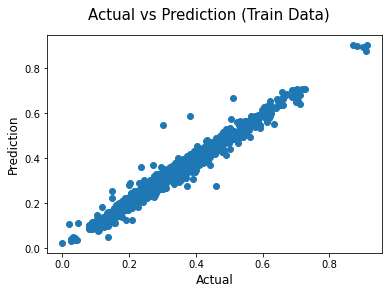

In [237]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train,prediction)
fig.suptitle('Actual vs Prediction (Train Data)', fontsize=15)   # Plot heading 
plt.xlabel('Actual', fontsize=12)                   # X-label
plt.ylabel('Prediction', fontsize=12) 
plt.savefig('../plots/Regression+ImageFeature/ActualvsPrediction-TrainData.png' ,bbox_inches="tight")

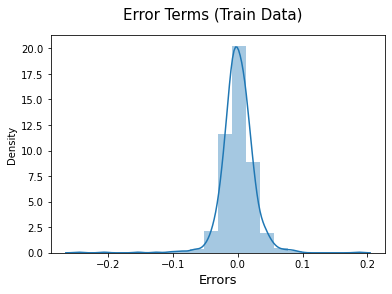

In [238]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - prediction), bins = 20)
fig.suptitle('Error Terms (Train Data)', fontsize = 15)      # Plot heading 
plt.xlabel('Errors', fontsize = 13)  
plt.savefig('../plots/Regression+ImageFeature/ErrorTerms-TrainData.png' ,bbox_inches="tight")

#### Error terms

In [239]:
#RMSE/MAE computation using sklearn library
from sklearn.metrics import *

In [240]:
print('Train set r2 score = ', r2_score(y_train, prediction))
print('Train set MAE = ', mean_absolute_error(y_train, prediction))
print('Train set MSE = ', mean_squared_error(y_train, prediction))
print('Train set RMSE = ', np.sqrt(mean_squared_error(y_train, prediction)))

Train set r2 score =  0.9705719167614087
Train set MAE =  0.017135734805676813
Train set MSE =  0.0006494461722068705
Train set RMSE =  0.02548423379673932


#### 5.1 Test Error Analysis

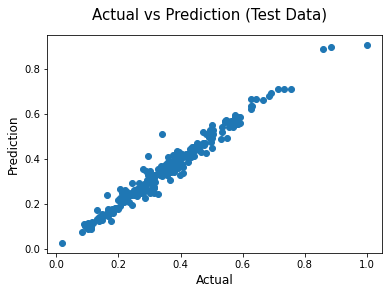

In [241]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,test_prediction)
fig.suptitle('Actual vs Prediction (Test Data)', fontsize=15)   # Plot heading 
plt.xlabel('Actual', fontsize=12)                   # X-label
plt.ylabel('Prediction', fontsize=12) 
plt.savefig('../plots/Regression+ImageFeature/ActualvsPrediction-TestData.png' ,bbox_inches="tight")

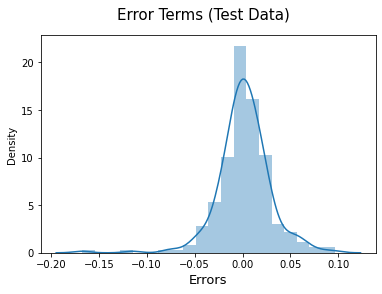

In [242]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - test_prediction), bins = 20)
fig.suptitle('Error Terms (Test Data)', fontsize = 15)                  # Plot heading 
plt.xlabel('Errors', fontsize = 13) 
plt.savefig('../plots/Regression+ImageFeature/ErrorTerms-TestData.png' ,bbox_inches="tight")

#### Error terms

In [243]:
print('Test set r2 score = ', r2_score(y_test, test_prediction))
print('Test set MAE = ', mean_absolute_error(y_test, test_prediction))
print('Test set MSE = ', mean_squared_error(y_test, test_prediction))
print('Test set RMSE = ', np.sqrt(mean_squared_error(y_test, test_prediction)))

Test set r2 score =  0.9674958628905121
Test set MAE =  0.019091311995581717
Test set MSE =  0.0007601647709844024
Test set RMSE =  0.02757108577811912
